## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm #Gives progress bar while we are training
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load and Preprocess Data

In [ ]:
#Download and load fashion-mnist data
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True)
test_data = tfds.load("fashion_mnist", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXDZZX7/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXDZZX7/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#Classes are encoded as integers. The naming below are given in english.
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Next, you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1). You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array.

In [ ]:
def format_image(data):        
    image = data["image"]             #Takes out the image from the data.
    image = tf.reshape(image, [-1])   #Flattens it into 1-D array
    image = tf.cast(image, 'float32') #Changes the data format to float32
    image = image / 255.0             #Normalize the data.
    return image, data["label"]       #Returns the image and the corresponding label

In [ ]:
#In tensorflow datasets the mapping function takes your function and applies it to the corresponding dataset.
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

Now you shuffle and batch your training and test datasets before feeding them to the model.

In [ ]:
batch_size = 64

#Takes first buffer_size images then picks random image from it to add it into the batch. Each time it picks an image at random from the buffer size and adds it to the batch, that entry in the buffer size is replaced with the next entry in the dataset.
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

#Just batches the data. No need of reshuffling.
test =  test_data.batch(batch_size=batch_size)

## Define the Model

In [ ]:
#Model design. A simple 2 layer fully connected architecture
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

#Model optimizer
optimizer = tf.keras.optimizers.Adam()

#Model loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics

You will also define metrics so that your training loop can update and display them. Here you are using `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [ ]:
#Model evaluation metrics
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop

The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [ ]:
#Function to apply gradients to the weights
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights)) #The zip kinds of concatenates the weights and biases moroney said.
  
  return logits, loss_value

This function performs training during one epoch. You run through all batches of training data in each epoch to make updates to trainable weights using your previous function. You can see that we also call update_state on your metrics to accumulate the value of your metrics.
You are displaying a progress bar to indicate completion of training in each epoch. Here you use tqdm for displaying the progress bar.

In [ ]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [ ]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Next you define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here you combine the functions you built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

**Note** : You also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [ ]:
#Get the model
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


  0%|          | 0/938 WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f094084c310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Training loss for step 937: 0.3328: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.5393  Validation Loss: 0.4372, Train Accuracy: 0.8127, Validation Accuracy 0.8437
Start of epoch 1


Training loss for step 937: 0.1525: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3902  Validation Loss: 0.4327, Train Accuracy: 0.8586, Validation Accuracy 0.8459
Start of epoch 2


Training loss for step 937: 0.2053: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3497  Validation Loss: 0.3725, Train Accuracy: 0.8724, Validation Accuracy 0.8671
Start of epoch 3


Training loss for step 937: 0.2571: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3239  Validation Loss: 0.3616, Train Accuracy: 0.8833, Validation Accuracy 0.8749
Start of epoch 4


Training loss for step 937: 0.3929: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.3068  Validation Loss: 0.3609, Train Accuracy: 0.8880, Validation Accuracy 0.8710
Start of epoch 5


Training loss for step 937: 0.1440: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.2933  Validation Loss: 0.3529, Train Accuracy: 0.8910, Validation Accuracy 0.8774
Start of epoch 6


Training loss for step 937: 0.2679: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2786  Validation Loss: 0.3503, Train Accuracy: 0.8967, Validation Accuracy 0.8767
Start of epoch 7


Training loss for step 937: 0.0557: 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2676  Validation Loss: 0.3376, Train Accuracy: 0.9008, Validation Accuracy 0.8840
Start of epoch 8


Training loss for step 937: 0.1986: 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2589  Validation Loss: 0.3497, Train Accuracy: 0.9034, Validation Accuracy 0.8794
Start of epoch 9


Training loss for step 937: 0.2151: 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.2476  Validation Loss: 0.3333, Train Accuracy: 0.9081, Validation Accuracy 0.8844


## Evaluate Model

### Plots for Evaluation
You plot the progress of loss as training proceeds over number of epochs.

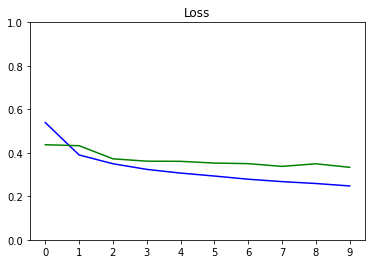

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.

In [ ]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

#Model prediction

You make predictions on the test dataset and plot the images with their true and predicted values.

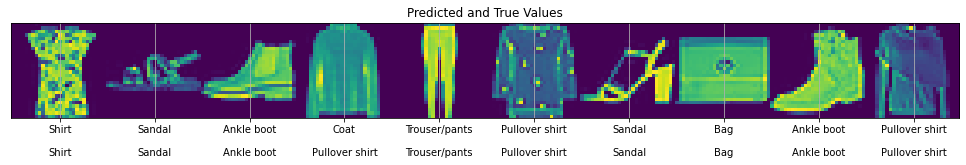

In [ ]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)